---
## 2. Collaborative Based Filtering

### Data Preparation and Exploratory Data Analysis

First we will do data cleaning for duplicates and null values.

In [1]:
#Import basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Load the data into data frames
df_reviews = pd.read_csv('data/reviews.csv')

In [3]:
#Check reviews dataset
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203284 entries, 0 to 203283
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     203284 non-null  int64 
 1   id             203284 non-null  int64 
 2   date           203284 non-null  object
 3   reviewer_id    203284 non-null  int64 
 4   reviewer_name  203284 non-null  object
 5   comments       203195 non-null  object
dtypes: int64(3), object(3)
memory usage: 9.3+ MB


In [4]:
#find percentage of null value by comparing to total rows
(df_reviews.isna().sum()/df_reviews.shape[0])

listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.000438
dtype: float64

In [5]:
#Drop the null rows, only 0.04%
df_reviews.dropna(subset =['comments'], inplace=True)

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203195 entries, 0 to 203283
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     203195 non-null  int64 
 1   id             203195 non-null  int64 
 2   date           203195 non-null  object
 3   reviewer_id    203195 non-null  int64 
 4   reviewer_name  203195 non-null  object
 5   comments       203195 non-null  object
dtypes: int64(3), object(3)
memory usage: 10.9+ MB


In [7]:
#Check duplicates for df_listings
df_reviews[df_reviews.duplicated()]

,listing_id,id,date,reviewer_id,reviewer_name,comments


I dropped null rows considering only 0.04% of total data points. Also, there is no duplicates value in the dataset. 

In the dataset, there is no review scores for each reviews from the users. In order to do colaborative filtering, we need the review score as the base. It means that we have to do unsupervised sentiment analysis. There are 2 commons library that are widely use to do the sentiment analysis easily, SentimentIntensityAnalyzer function from NLTK VADER package and TextBlob. Let's try both and see which one is better for our purpose.

I will start with NLTK VADER library.

In [8]:
#Lowercase the comments column 
df_reviews['comments'] = df_reviews['comments'].str.lower()

In [9]:
#Import package from NLTK
import nltk
import nltk.data
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize

In [10]:
#Download vader_lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\reyna\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [11]:
#Set the SentimentIntensityAnalyzer function
sia = SentimentIntensityAnalyzer()

In [12]:
#Check 1 row of the comments to test the function
df_reviews['comments'][0]

'this accommodation was excellent. beautiful space, nicely appointed, clean, amazing view, location is great and there is a parking space for a small fee. our check in went on time and smoothly, simon was very pleasant to deal with. all around happy experience.'

In [13]:
#Test the function
sia.polarity_scores(df_reviews['comments'][0])

{'neg': 0.0, 'neu': 0.538, 'pos': 0.462, 'compound': 0.9824}

From the function, we can use compound value. The interpretation of the value is:
- positive sentiment : compound score >= 0.5
- neutral sentiment  : compound score < 0.5 and compound score >= -0.5
- negative sentiment : compound score <= -0.5

We can learn from the sample comment that it is a positive sentiment. We can use this score as estimation of review score.

In [14]:
#Get the compound score for sample comment
sia.polarity_scores(df_reviews['comments'][0])['compound']

0.9824

In [15]:
#Create new column for the compound score (will use polarity as terminology from here)
df_reviews['vader_polarity'] = df_reviews.comments.apply(lambda x: sia.polarity_scores(x)['compound'])

In [16]:
#Check the value
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,vader_polarity
0,10080,720466,2011-11-15,143771,Anthony,this accommodation was excellent. beautiful sp...,0.9824
1,10080,786114,2011-12-14,1472653,Nilesh,the host canceled my reservation 13 days befor...,0.0000
2,10080,989885,2012-03-12,1433564,Avril,"this apartment is fantastic, just what i and m...",0.9595
3,10080,1419559,2012-06-05,725806,Dennis,very nice apartment and great view. close to s...,0.6997
4,10080,3354964,2013-01-15,3641867,Jude,both rami and mauricio made our family of 5 fe...,0.9694


Now we have the polarity score from VADER library. Let's see the distribution.

Text(0, 0.5, '# of Reviews')

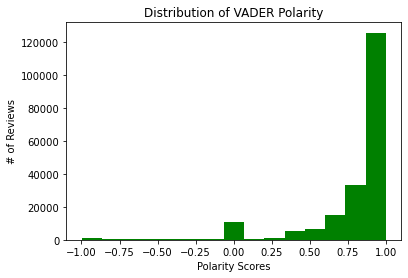

In [17]:
#See the distribution of the polarity score
plt.figure()
plt.hist(df_reviews['vader_polarity'], bins=15, color="green")
plt.title('Distribution of VADER Polarity')
plt.xlabel('Polarity Scores')
plt.ylabel('# of Reviews')

We can see most reviews has positive sentiment. Next, I will try the second library from TextBlob.

In [19]:
#Import TextBlob package
from textblob import TextBlob

#Get the polarity score using below function
def get_textBlob_score(sent):
    #This polarity score is between -1 to 1
    polarity = TextBlob(sent).sentiment.polarity
    return polarity

In [20]:
#Test the function using the same sample
TextBlob(df_reviews['comments'][0]).sentiment.polarity

0.612

In [21]:
#Create new column for the polarity score
df_reviews['TB_polarity'] = df_reviews.comments.apply(lambda x: get_textBlob_score(x))

Text(0, 0.5, '# of Reviews')

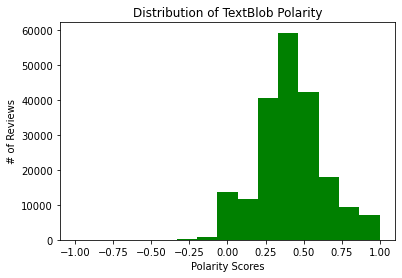

In [22]:
#See the distribution of the polarity score
plt.figure()
plt.hist(df_reviews['TB_polarity'], bins=15, color="green")
plt.title('Distribution of TextBlob Polarity')
plt.xlabel('Polarity Scores')
plt.ylabel('# of Reviews')

We still have positive review as majority, but we can see more normalize data than the other. It is understandable that we have wider distribution for positive review because all positive value means positive sentiment (range between 0 and 1), while in VADER the range is between 0.5 and 1. While there is no right or wrong in both methods, I will pick TextBlob polarity score because it will be useful for modelling purpose (later on) considering the distribution.

Next, I will do MinMaxScaler to scale the data and put the value between 0 and 1.

In [23]:
#Import the Scaler
from sklearn.preprocessing import MinMaxScaler

#instantiate the scaler
MM = MinMaxScaler()

df_polarity = pd.DataFrame(df_reviews['TB_polarity'])

#Fit the scaler
MM.fit(df_polarity)

#Transform
df_polarity = MM.transform(df_polarity)

In [24]:
df_polarity

array([[0.806     ],
       [0.5       ],
       [0.56977513],
       ...,
       [1.        ],
       [0.72756579],
       [0.955     ]])

Text(0, 0.5, '# of Reviews')

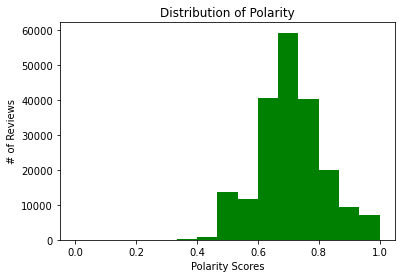

In [26]:
#See the distribution of the polarity score
plt.figure()
plt.hist(df_polarity, bins=15, color="green")
plt.title('Distribution of Polarity')
plt.xlabel('Polarity Scores')
plt.ylabel('# of Reviews')

In [27]:
#Put the polarity data into reviews dataframe
df_reviews['polarity'] = df_polarity

In [28]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,vader_polarity,TB_polarity,polarity
0,10080,720466,2011-11-15,143771,Anthony,this accommodation was excellent. beautiful sp...,0.9824,0.612000,0.806000
1,10080,786114,2011-12-14,1472653,Nilesh,the host canceled my reservation 13 days befor...,0.0000,0.000000,0.500000
2,10080,989885,2012-03-12,1433564,Avril,"this apartment is fantastic, just what i and m...",0.9595,0.139550,0.569775
3,10080,1419559,2012-06-05,725806,Dennis,very nice apartment and great view. close to s...,0.6997,0.377143,0.688571
4,10080,3354964,2013-01-15,3641867,Jude,both rami and mauricio made our family of 5 fe...,0.9694,0.328351,0.664175


We are good now with the standardized polarity score. Next, I will check total review of each reviewer.

In [29]:
#See total review per reviewer
df_review_by_reviewer = df_reviews.groupby('reviewer_id', as_index=False)['reviewer_id'].agg({'id_count':'count'})
df_review_by_reviewer

,reviewer_id,id_count
0,54,1
1,1956,2
2,1969,1
3,2813,1
4,2852,1
...,...,...
185446,345003502,1
185447,345004289,1
185448,345465765,1
185449,345469062,1


In [30]:
df_review_by_reviewer.sort_values('id_count', ascending=False).head(10)

,reviewer_id,id_count
28811,11967216,34
52159,26599167,27
93419,64336918,21
11771,3960298,19
19758,7196338,17
2889,791723,16
176671,264125508,16
148147,165011407,15
141751,148316850,15
163615,210164562,15


Text(0, 0.5, 'Distribution')

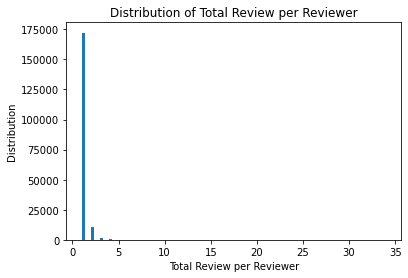

In [31]:
#See the distribution of total review per reviewer
plt.figure()
plt.hist(df_review_by_reviewer['id_count'], bins=100)
plt.title('Distribution of Total Review per Reviewer')
plt.xlabel('Total Review per Reviewer')
plt.ylabel('Distribution')

Most reviewer only gave small amount of review. Let's see the detail amount.

In [32]:
#See the distribution of total review per reviewer
df_review_by_reviewer_dist = df_review_by_reviewer.groupby('id_count', as_index=False)['id_count'].agg({'distribution':'count'})
df_review_by_reviewer_dist['percentage'] = df_review_by_reviewer_dist['distribution']/df_review_by_reviewer_dist['distribution'].sum()
df_review_by_reviewer_dist

,id_count,distribution,percentage
0,1,172226,0.928687
1,2,10577,0.057034
2,3,1773,0.009560
3,4,475,0.002561
4,5,199,0.001073
5,6,84,0.000453
6,7,42,0.000226
7,8,24,0.000129
8,9,15,0.000081
9,10,14,0.000075


Well, almost 93% of reviewers only have 1 review. It seems those are tourists that come to the city once only. How about total reviews per listings.

In [33]:
#See total review per listings
df_review_by_listing = df_reviews.groupby('listing_id', as_index=False)['listing_id'].agg({'id_count':'count'})
df_review_by_listing
df_review_by_listing.sort_values('id_count', ascending=False).head(10)

,listing_id,id_count
348,3812348,662
30,77157,634
461,5471844,517
244,2592307,516
349,3829365,503
36,125176,490
931,13383325,484
612,7639521,480
31,98242,468
335,3629071,454


In [34]:
#See the distribution of total review per listing
df_review_by_listing_dist = df_review_by_listing.groupby('id_count', as_index=False)['id_count'].agg({'distribution':'count'})
df_review_by_listing_dist['percentage'] = df_review_by_listing_dist['distribution']/df_review_by_listing_dist['distribution'].sum()
df_review_by_listing_dist

,id_count,distribution,percentage
0,1,406,0.082220
1,2,291,0.058931
2,3,206,0.041717
3,4,215,0.043540
4,5,170,0.034427
...,...,...,...
287,503,1,0.000203
288,516,1,0.000203
289,517,1,0.000203
290,634,1,0.000203


Text(0, 0.5, 'Distribution')

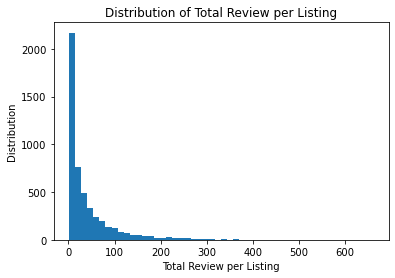

In [35]:
#See the distribution of total review per listing
plt.figure()
plt.hist(df_review_by_listing['id_count'], bins=50)
plt.title('Distribution of Total Review per Listing')
plt.xlabel('Total Review per Listing')
plt.ylabel('Distribution')

Even though we still see many listings with few reviews only, but we still have quite amount of listings with many reviews.

Considering above results, it seems that user-item filtering won't be useful here fo most of the users. For example, we have reviewer A that has 1 review to listing X. Then, we try to find other reviewer that also review listing X, find reviewer B. But reviewer B also only has review to this listing only. We can't give recommendation to other listings because 93% reviewer only has 1 review. 

Same scenario with item-item filtering since we have to find users who has reviews for the sample and other listings. Even though we have many reviews for several listings, but mostly it came from different users.

In that case, we can't have a collaborative recommender system for most users. But, how about the users that has several reviews for severals listings? We can try to build a recommender system for them. Let's filter the data for listings where at least have 2 reviews and for reviewers who at least has 2 reviews.

In [36]:
#Put the data in simple df format
df_reviews_fin = df_reviews[['listing_id','reviewer_id','polarity']]
df_reviews_fin.shape

(203195, 3)

Before that, I will check if any reviewer gave review to same listing in different time.

In [37]:
#Check duplicates comparing listing_id and reviewer_id
df_duplicate = df_reviews[df_reviews[['reviewer_id', 'listing_id']].duplicated()]
df_duplicate.sort_values(["reviewer_id", "listing_id"])

,listing_id,id,date,reviewer_id,reviewer_name,comments,vader_polarity,TB_polarity,polarity
77214,14074129,244540579,2018-03-18,6431,Paula,"thank you, colin! fabulous stay in comfortable...",0.9380,0.356250,0.678125
1718,19527,319961713,2018-09-07,12483,Jill,my favourite place to stay! love coming here. ...,0.9137,0.500000,0.750000
1723,19527,469500471,2019-06-14,12483,Jill,my home away from home. i love staying here! i...,0.9564,0.308429,0.654214
1732,19527,536005430,2019-09-25,12483,Jill,i try to stay here every time i come to vancou...,0.9819,0.364551,0.682276
27524,3678989,331097606,2018-10-01,18100,Chihiro,kriszta’s place is lovely and is a great value...,0.9824,0.263750,0.631875
...,...,...,...,...,...,...,...,...,...
120393,20747473,624174928,2020-05-07,343774597,Joanne,"highly recommend, and will always return great...",0.8803,0.373333,0.686667
203079,42475163,622921443,2020-04-22,343774597,Joanne,always a pleasure. thank you for everything,0.7351,0.000000,0.500000
203080,42475163,622973677,2020-04-23,343774597,Joanne,"always a pleasure, enjoy staying here highly r...",0.9095,0.280000,0.640000
203081,42475163,623101692,2020-04-25,343774597,Joanne,always a comfortable stay. highly recommend. ...,0.9242,0.272000,0.636000


There are many duplicates. It's possible when someone likes to stay in one play, they will stay again at the same place in different time and put another review. I will group those data and get the mean value of polarity.

In [38]:
#Group by listing_id and reviewer_id and calculate the mean of polarity
df_reviews_by_listing_reviewer = df_reviews[['listing_id','reviewer_id','polarity']].groupby(['listing_id', 'reviewer_id']).agg({'polarity': 'mean'}).reset_index()
df_reviews_by_listing_reviewer.head()

,listing_id,reviewer_id,polarity
0,10080,143771,0.806000
1,10080,725806,0.688571
2,10080,825299,0.833333
3,10080,1433564,0.569775
4,10080,1472653,0.500000


In [39]:
#Check the shape
df_reviews_by_listing_reviewer.shape

(200751, 3)

In [40]:
#Select df where count(listing_id) >= 2
df_listing_count = df_reviews_by_listing_reviewer['listing_id'].value_counts()
df_reviews_by_listing_reviewer = df_reviews_by_listing_reviewer[df_reviews_by_listing_reviewer['listing_id'].isin(df_listing_count[df_listing_count >= 2].index)]
df_reviews_by_listing_reviewer.shape

(200342, 3)

In [41]:
#Select df where count(reviewer_id) >= 2
df_reviewer_count = df_reviews_by_listing_reviewer['reviewer_id'].value_counts()
df_reviews_by_listing_reviewer = df_reviews_by_listing_reviewer[df_reviews_by_listing_reviewer['reviewer_id'].isin(df_reviewer_count[df_reviewer_count >= 2].index)]
df_reviews_by_listing_reviewer.shape

(27106, 3)

Next I will build the user-item matrix table.

In [42]:
#Get list of reviewers
reviewers = df_reviews_by_listing_reviewer['reviewer_id'].unique()

#Put into data frame and set a new id for reviewer using their sort index, this is for the purpose of our logic in the function
df_reviewer = pd.DataFrame(reviewers).sort_values(0).reset_index()
df_reviewer.drop(columns=['index'], inplace=True)
df_reviewer = df_reviewer.reset_index()
df_reviewer.columns = ['new_reviewer_id', 'reviewer_id']
df_reviewer['new_reviewer_id'] += 1
df_reviewer.head()

,new_reviewer_id,reviewer_id
0,1,1956
1,2,4662
2,3,6431
3,4,7439
4,5,10904


In [43]:
#Merge the new reviewer id with df_reviews_by_listing_reviewer dataset
df_reviews_by_listing_reviewer = (df_reviews_by_listing_reviewer.merge(df_reviewer, left_on='reviewer_id', right_on='reviewer_id')
          .reindex(columns=['listing_id', 'reviewer_id', 'polarity', 'new_reviewer_id']))
df_reviews_by_listing_reviewer.head()

,listing_id,reviewer_id,polarity,new_reviewer_id
0,10080,825299,0.833333,283
1,7432239,825299,0.746065,283
2,10080,1914168,0.900000,574
3,13358,1914168,0.773571,574
4,3401626,1914168,0.900000,574


In [44]:
#Get list of listings
listings = df_reviews_by_listing_reviewer['listing_id'].unique()

#Put into data frame and set a new id for listing using their sort index, this is for the purpose of our logic in the function
df_listing = pd.DataFrame(listings).sort_values(0).reset_index()
df_listing.drop(columns=['index'], inplace=True)
df_listing = df_listing.reset_index()
df_listing.columns = ['new_listing_id', 'listing_id']
df_listing['new_listing_id'] += 1
df_listing.head()

,new_listing_id,listing_id
0,1,10080
1,2,13188
2,3,13357
3,4,13358
4,5,13490


In [45]:
#Merge the new listing id with df_reviews_by_listing_reviewer dataset
df_reviews_by_listing_reviewer = (df_reviews_by_listing_reviewer.merge(df_listing, left_on='listing_id', right_on='listing_id')
          .reindex(columns=['listing_id', 'reviewer_id', 'polarity', 'new_reviewer_id', 'new_listing_id']))
df_reviews_by_listing_reviewer.head()

,listing_id,reviewer_id,polarity,new_reviewer_id,new_listing_id
0,10080,825299,0.833333,283,1
1,10080,1914168,0.900000,574,1
2,10080,3014596,0.779762,837,1
3,7432239,825299,0.746065,283,521
4,7432239,55586890,0.670000,6305,521


In [46]:
#Set variable for len of each unique reviewers and listings
num_reviewers = len(reviewers)
num_listings = len(listings)
           
#Set value to -1 for listings that hasn't been reviewed by the reviewer
R = np.full((num_reviewers,num_listings), -1.0)

In [47]:
#Build the user-item matrix
for row in df_reviews_by_listing_reviewer.itertuples() :
    reviewer = row[4]
    listing = row[5]
    polarity = row[3]
    R[reviewer-1, listing-1] = polarity
R.shape

(11889, 3795)

In [48]:
#Check the R value
R

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

#### Item-item filtering

In [49]:
#Import the cosine_similarity package
from sklearn.metrics.pairwise import cosine_similarity

In [50]:
#Pick a reviewer who has reviewed the most
df_reviews_by_listing_reviewer['new_reviewer_id'].value_counts().head(1)

2409    25
Name: new_reviewer_id, dtype: int64

We got user id 2409 with 25 reviews.

In [51]:
#Check listing that this reviewer hasn't reviewed and has the most reviews 
df_reviews_by_listing_reviewer[df_reviews_by_listing_reviewer['new_reviewer_id'] != 2409]['new_listing_id'].value_counts().head(1)

26    89
Name: new_listing_id, dtype: int64

We got listing id 26 with 89 reviews.

In [52]:
#Set variable for sample listing and reviewer
the_listing = 26
the_reviewer = 2409

#Set lists to append to 
polarity_on_listings = []
item_similarity = []

#Loop all listings
for each_listing in range(0, R.shape[1]):
    
    #if the_reviewer hasn't rated this each_listing then skip to the next listing 
    if R[the_reviewer-1, each_listing-1] == -1: 
        continue
   
    #To check if there are any reviewers who've rated the_listing and each_listing
    mask = ((R[:, the_listing-1] != -1) & (R[:, each_listing-1] != -1))
    
    #Make sure that both listings have at least one reviewer in common (so at least one True in mask) 
    if not True in mask: 
        continue
   
    print(f'Listing id:{each_listing}')
          
    #Use the above mask to get the polarities for both listings
    #Reshape for cosine_similarity
    the_listing_polarities = R[mask, the_listing-1].reshape(1, -1)
    each_listing_polarities = R[mask, each_listing-1].reshape(1, -1)
    
    print(f'Sample listing polarities: {the_listing_polarities}')
    print(f'Listing to compare polarities: {each_listing_polarities}')
    
    similarity = cosine_similarity(the_listing_polarities, each_listing_polarities)
    print(f'Cosine similarity: {similarity}')
          
    #See how similarly the_listing and each_listing were rated by reviewers by calulating the cosine distance between their polarities
    item_similarity.append(similarity)
    
    #Get the polarity that the_reviewer gave each_listing
    polarity_on_listings.append(R[the_reviewer-1, each_listing-1]) 
    
item_similarity = np.array(item_similarity).reshape(1,-1)

print(item_similarity, '\n')
print(polarity_on_listings)

Listing id:908
Sample listing polarities: [[0.658625]]
Listing to compare polarities: [[0.95]]
Cosine similarity: [[1.]]
Listing id:938
Sample listing polarities: [[0.75066964]]
Listing to compare polarities: [[0.7]]
Cosine similarity: [[1.]]
Listing id:1290
Sample listing polarities: [[0.74469866 0.9       ]]
Listing to compare polarities: [[0.6878125 0.7625   ]]
Cosine similarity: [[0.99908874]]
Listing id:2546
Sample listing polarities: [[0.61875]]
Listing to compare polarities: [[0.60208333]]
Cosine similarity: [[1.]]
[[1.         1.         0.99908874 1.        ]] 

[0.6491666666666667, 0.7333333333333334, 0.7768333333333334, 0.8722222222222222]


This is not good. Even when we use reviewer who has given many reviews and pick a listing that has quite amount of reviews, we only can find 4 listings, and each listing only has 1 user that review that specific listing. Since we did the vector to count the distance, it has high value of similarity ( 1 and 0.999) because we only have 1 or 2 dimension data for each listing. Obviously we can't use this method for the recommender system. Let's try the user-item filtering.

#### User-Item filtering

In [53]:
#Set variable for sample listing and reviewer
the_listing = 26
the_reviewer = 2409

#Set lists to append to 
the_listing_polarities = []
reviewer_similarity = []

#Loop all reviewers
for each_reviewer in range(0, R.shape[0]):
    
    #if each_reviewer hasn't rated the sample listing then skip to the next user
    if R[each_reviewer-1, the_listing-1] == -1:
        continue
        
    #To check if there are any listings which has been rated by sample reviewer and each reviewer
    mask = ((R[the_reviewer-1, :] != -1) & (R[each_reviewer-1, :] != -1))

    #Make sure that both reviewers have at least one listing in common (so at least one True in mask)
    if not True in mask: 
        continue
    
    #Use the above mask to get the polarities for both reviewers
    #Reshape for cosine_similarity
    the_reviewer_polarities = R[the_reviewer-1, mask].reshape(1, -1)
    each_reviewer_polarities = R[each_reviewer-1, mask].reshape(1, -1)
    
    print(f'Reviewer id: {each_reviewer}')
    print(f'Sample reviewer polarities: {the_reviewer_polarities}')
    print(f'Reviewer to compare polarities: {each_reviewer_polarities}')
    
    similarity = cosine_similarity(the_reviewer_polarities, each_reviewer_polarities)
    print(f'Cosine similarity: {similarity}')
    
    #See how similarly the_reviewer and each_reviewer gave polarity score by calulating the cosine distance between their polarities
    reviewer_similarity.append(similarity)
    
    #Get the polarity that each_reviewer gave to the sample listing
    the_listing_polarities.append(R[each_reviewer-1, the_listing-1])
    
reviewer_similarity = np.array(reviewer_similarity).reshape(1,-1)


print(reviewer_similarity, '\n')
print(the_listing_polarities)

Reviewer id: 185
Sample reviewer polarities: [[0.77683333]]
Reviewer to compare polarities: [[0.6878125]]
Cosine similarity: [[1.]]
Reviewer id: 1076
Sample reviewer polarities: [[0.87222222]]
Reviewer to compare polarities: [[0.60208333]]
Cosine similarity: [[1.]]
Reviewer id: 5734
Sample reviewer polarities: [[0.64916667]]
Reviewer to compare polarities: [[0.95]]
Cosine similarity: [[1.]]
Reviewer id: 6822
Sample reviewer polarities: [[0.73333333]]
Reviewer to compare polarities: [[0.7]]
Cosine similarity: [[1.]]
Reviewer id: 8386
Sample reviewer polarities: [[0.77683333]]
Reviewer to compare polarities: [[0.7625]]
Cosine similarity: [[1.]]
[[1. 1. 1. 1. 1.]] 

[0.7446986607142857, 0.61875, 0.658625, 0.7506696428571429, 0.9]


It has the same pattern. We can see all the similarity scores are 1 due to only 1 dimension for each reviewer polarity to be compared. Having said that, we can't do collaborative recommender system with above manual function of user-item and item-item filtering using this dataset.

Luckily, there is a modelling package from Surprise library that widely used for collaborative filtering. I will do the activity in the next ipynb file. For now, I will download the final dataset to csv file so we don't have to repeat several steps above.

In [54]:
#I will save the clean df to csv file to be used for modelling purpose
df_reviews_fin = df_reviews_by_listing_reviewer[['reviewer_id','listing_id','polarity']]
df_reviews_fin.shape
df_reviews_fin.to_csv('data/reviews_polarity.csv')

---
##### (Continue to 3_Collaborative_with_Modelling)
---